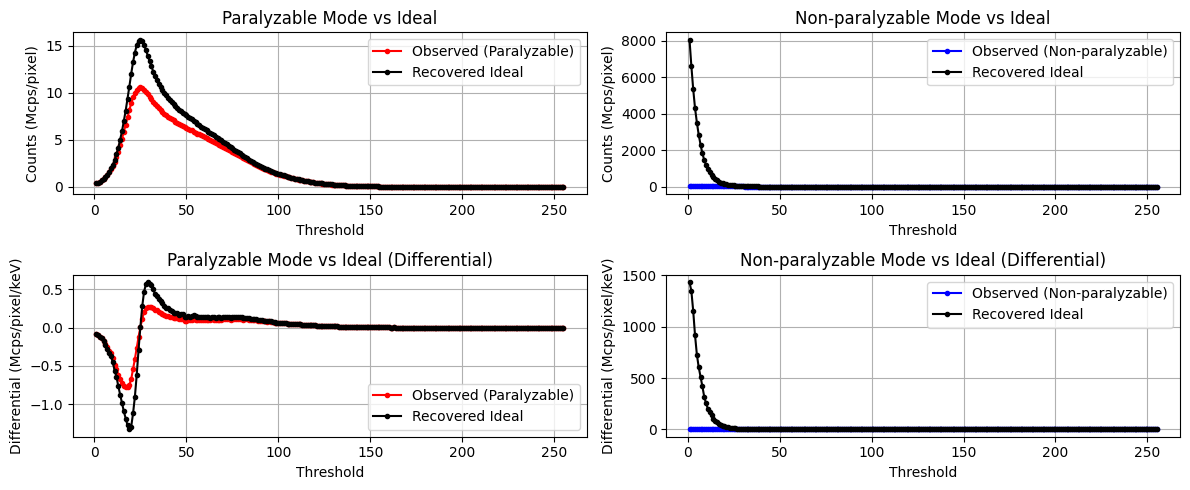

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import lambertw

# ---------------- 参数 ----------------
tau = 25e-9   # 死时间 (秒)，例如 25 ns

# ---------------- 读取数据 ----------------
# 假设文件为 data.csv，三列：Threshold, Paralyzable, Nonparalyzable
df = pd.read_csv("120kv_data.csv")   # 或 pd.read_csv("data.csv")

threshold = df.iloc[1:,0].values
R_obs_para = df.iloc[1:,1].values * 1e6   # 转换为 cps
R_obs_nonpara = df.iloc[1:,2].values * 1e6

# ---------------- 反推理想计数率 ----------------
# 非瘫痪模式反推公式： R = R_obs / (1 - R_obs * tau)
def recover_nonpar(R_obs, tau):
    return R_obs / (1 - R_obs * tau)

# 瘫痪模式反推公式： R = -1/tau * W(-R_obs * tau)
def recover_par(R_obs, tau):
    R = []
    for robs in R_obs:
        if robs * tau >= 1/np.e:  
            R.append(np.nan)  # 超过退化区，无法唯一恢复
        else:
            R_val = -1.0/tau * lambertw(-robs * tau).real
            R.append(R_val)
    return np.array(R)

R_ideal_para = recover_par(R_obs_para, tau)
R_ideal_nonpara = recover_nonpar(R_obs_nonpara, tau)

# ---------------- 微分谱计算 ----------------
def differential(threshold, integral):
    return -np.gradient(integral, threshold)

D_obs_para = differential(threshold, R_obs_para)
D_ideal_para = differential(threshold, R_ideal_para)

D_obs_nonpara = differential(threshold, R_obs_nonpara)
D_ideal_nonpara = differential(threshold, R_ideal_nonpara)

# ---------------- 绘图 ----------------
plt.figure(figsize=(12,5))

# 瘫痪模式
plt.subplot(2,2,1)
plt.plot(threshold, R_obs_para/1e6, 'r.-', label="Observed (Paralyzable)")
plt.plot(threshold, R_ideal_para/1e6, 'k.-', label="Recovered Ideal")
plt.xlabel("Threshold")
plt.ylabel("Counts (Mcps/pixel)")
plt.title("Paralyzable Mode vs Ideal")
plt.legend()
plt.grid(True)

# 非瘫痪模式
plt.subplot(2,2,2)
plt.plot(threshold, R_obs_nonpara/1e6, 'b.-', label="Observed (Non-paralyzable)")
plt.plot(threshold, R_ideal_nonpara/1e6, 'k.-', label="Recovered Ideal")
plt.xlabel("Threshold")
plt.ylabel("Counts (Mcps/pixel)")
plt.title("Non-paralyzable Mode vs Ideal")
plt.legend()
plt.grid(True)


# 微分谱：瘫痪
plt.subplot(2,2,3)
plt.plot(threshold, D_obs_para/1e6, 'r.-', label="Observed (Paralyzable)")
plt.plot(threshold, D_ideal_para/1e6, 'k.-', label="Recovered Ideal")
plt.xlabel("Threshold")
plt.ylabel("Differential (Mcps/pixel/keV)")
plt.title("Paralyzable Mode vs Ideal (Differential)")
plt.legend()
plt.grid(True)

# 微分谱：非瘫痪
plt.subplot(2,2,4)
plt.plot(threshold, D_obs_nonpara/1e6, 'b.-', label="Observed (Non-paralyzable)")
plt.plot(threshold, D_ideal_nonpara/1e6, 'k.-', label="Recovered Ideal")
plt.xlabel("Threshold")
plt.ylabel("Differential (Mcps/pixel/keV)")
plt.title("Non-paralyzable Mode vs Ideal (Differential)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
